## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, ReLU, Dropout
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], is_norm_after_ac=True, l2ratio=1e-4, drop=0.25):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,  
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2ratio))(input_layer)
            if is_norm_after_ac == True:
                x = ReLU()(x)
                x = BatchNormalization()(x)
            else:
                x = BatchNormalization()(x)
                x = ReLU()(x)
            x = Dropout(drop)(x)
        else:
            x = keras.layers.Dense(units=n_units,  
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2ratio))(x)
            if is_norm_after_ac == True:
                x = ReLU()(x)
                x = BatchNormalization()(x)
            else:
                x = BatchNormalization()(x)
                x = ReLU()(x)
            x = Dropout(drop)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
MOMENTUM = 0.95
BATCH_SIZE = [32, 256]
L2_EXP = [1e-4, 1e-12]
IS_NORM_AFTER_AC = [True, False]
DROPOUT = [0.25, 0.75]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for is_norm_after_ac in IS_NORM_AFTER_AC:
    for l2ratio in L2_EXP:
        for drop in DROPOUT:
            model = build_mlp(input_shape=x_train.shape[1:], is_norm_after_ac=is_norm_after_ac, l2ratio=l2ratio, drop=drop)
            model.summary()
            optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
            model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

            for batch in BATCH_SIZE:
                model.fit(x_train, y_train, 
                          epochs=EPOCHS, 
                          batch_size=batch, 
                          validation_data=(x_test, y_test), 
                          shuffle=True)

                # Collect results
                train_loss = model.history.history["loss"]
                valid_loss = model.history.history["val_loss"]
                train_acc = model.history.history["acc"]
                valid_acc = model.history.history["val_acc"]

                results['batch_'+str(batch)+"_is_norm_after_ac="+str(is_norm_after_ac)+"_drop="+str(drop)+"l2ratio="+str(l2ratio)] = [train_loss, valid_loss, train_acc, valid_acc]

W0722 14:27:18.268146 4395685312 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0722 14:27:18.278645 4395685312 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0722 14:27:18.280826 4395685312 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0722 14:27:18.338104 4395685312 deprecation_wrapper.py:119] From /Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0         
__________

50000/50000 [==============================] - 16s 311us/step - loss: 1.6040 - acc: 0.4647 - val_loss: 1.5443 - val_acc: 0.4795
Epoch 44/50
50000/50000 [==============================] - 15s 307us/step - loss: 1.5983 - acc: 0.4683 - val_loss: 1.5565 - val_acc: 0.4819
Epoch 45/50
50000/50000 [==============================] - 15s 308us/step - loss: 1.5983 - acc: 0.4684 - val_loss: 1.5309 - val_acc: 0.4868
Epoch 46/50
50000/50000 [==============================] - 15s 309us/step - loss: 1.5877 - acc: 0.4716 - val_loss: 1.5282 - val_acc: 0.4829
Epoch 47/50
50000/50000 [==============================] - 15s 308us/step - loss: 1.5821 - acc: 0.4731 - val_loss: 1.4849 - val_acc: 0.5063
Epoch 48/50
50000/50000 [==============================] - 16s 310us/step - loss: 1.5929 - acc: 0.4674 - val_loss: 1.5049 - val_acc: 0.4971
Epoch 49/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.5800 - acc: 0.4730 - val_loss: 1.5128 - val_acc: 0.4975
Epoch 50/50
50000/50000 [=======

W0722 14:43:52.325594 4395685312 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0722 14:43:52.416442 4395685312 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0722 14:43:52.503923 4395685312 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
re_lu_4 (ReLU)               (None, 512)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
re_lu_5 (ReLU)               (None, 256)               0         
__________

50000/50000 [==============================] - 15s 300us/step - loss: 2.0492 - acc: 0.2784 - val_loss: 1.9049 - val_acc: 0.3593
Epoch 44/50
50000/50000 [==============================] - 15s 307us/step - loss: 2.0457 - acc: 0.2789 - val_loss: 1.8994 - val_acc: 0.3554
Epoch 45/50
50000/50000 [==============================] - 15s 302us/step - loss: 2.0473 - acc: 0.2772 - val_loss: 1.9019 - val_acc: 0.3568
Epoch 46/50
50000/50000 [==============================] - 15s 301us/step - loss: 2.0547 - acc: 0.2732 - val_loss: 1.9112 - val_acc: 0.3559
Epoch 47/50
50000/50000 [==============================] - 15s 301us/step - loss: 2.0612 - acc: 0.2658 - val_loss: 1.9338 - val_acc: 0.3430
Epoch 48/50
50000/50000 [==============================] - 15s 297us/step - loss: 2.0711 - acc: 0.2630 - val_loss: 1.9275 - val_acc: 0.3340
Epoch 49/50
50000/50000 [==============================] - 15s 297us/step - loss: 2.0596 - acc: 0.2658 - val_loss: 1.9119 - val_acc: 0.3462
Epoch 50/50
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 16s 322us/step - loss: 1.9473 - acc: 0.3151 - val_loss: 1.6872 - val_acc: 0.3906
Epoch 2/50
50000/50000 [==============================] - 15s 304us/step - loss: 1.7356 - acc: 0.3766 - val_loss: 1.6478 - val_acc: 0.4092
Epoch 3/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.6906 - acc: 0.3938 - val_loss: 1.5965 - val_acc: 0.4336
Epoch 4/50
50000/50000 [==============================] - 15s 306us/step - loss: 1.6650 - acc: 0.4065 - val_loss: 1.5658 - val_acc: 0.4309
Epoch 5/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.6581 - acc: 0.4069 - val_loss: 1.5718 - val_acc: 0.4369
Epoch 6/50
50000/50000 [==============================] - 15s 302us/step - loss: 1.6467 - acc: 0.4127 - val_loss: 1.5506 - val_acc: 0.4440
Epoch 7/50
50000/50000 [==============================] - 15s 296us/step - loss: 1.6500 - acc: 0.4095 - val_loss: 1.

50000/50000 [==============================] - 4s 89us/step - loss: 1.3242 - acc: 0.5286 - val_loss: 1.3281 - val_acc: 0.5218
Epoch 10/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.3244 - acc: 0.5263 - val_loss: 1.3140 - val_acc: 0.5270
Epoch 11/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.3260 - acc: 0.5265 - val_loss: 1.3047 - val_acc: 0.5298
Epoch 12/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.3220 - acc: 0.5281 - val_loss: 1.3096 - val_acc: 0.5278
Epoch 13/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.3242 - acc: 0.5292 - val_loss: 1.3120 - val_acc: 0.5279
Epoch 14/50
50000/50000 [==============================] - 4s 84us/step - loss: 1.3160 - acc: 0.5282 - val_loss: 1.3193 - val_acc: 0.5225
Epoch 15/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.3220 - acc: 0.5287 - val_loss: 1.3182 - val_acc: 0.5305
Epoch 16/50
50000/50000 [=====================

W0722 15:16:23.270394 4395685312 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0722 15:16:23.358428 4395685312 nn_ops.py:4224] Large dropout rate: 0.75 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
re_lu_10 (ReLU)              (None, 512)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
re_lu_11 (ReLU)              (None, 256)               0         
__________

50000/50000 [==============================] - 16s 316us/step - loss: 1.9457 - acc: 0.2805 - val_loss: 1.7970 - val_acc: 0.3521
Epoch 44/50
50000/50000 [==============================] - 15s 309us/step - loss: 1.9386 - acc: 0.2846 - val_loss: 1.7986 - val_acc: 0.3556
Epoch 45/50
50000/50000 [==============================] - 16s 316us/step - loss: 1.9350 - acc: 0.2877 - val_loss: 1.8025 - val_acc: 0.3568
Epoch 46/50
50000/50000 [==============================] - 16s 313us/step - loss: 1.9319 - acc: 0.2860 - val_loss: 1.7918 - val_acc: 0.3570
Epoch 47/50
50000/50000 [==============================] - 16s 322us/step - loss: 1.9348 - acc: 0.2863 - val_loss: 1.7865 - val_acc: 0.3633
Epoch 48/50
50000/50000 [==============================] - 15s 310us/step - loss: 1.9392 - acc: 0.2859 - val_loss: 1.8027 - val_acc: 0.3499
Epoch 49/50
50000/50000 [==============================] - 16s 310us/step - loss: 1.9405 - acc: 0.2858 - val_loss: 1.7908 - val_acc: 0.3658
Epoch 50/50
50000/50000 [=======

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 17s 348us/step - loss: 2.0184 - acc: 0.3304 - val_loss: 1.7626 - val_acc: 0.4287
Epoch 2/50
50000/50000 [==============================] - 17s 333us/step - loss: 1.8001 - acc: 0.4026 - val_loss: 1.6394 - val_acc: 0.4722
Epoch 3/50
50000/50000 [==============================] - 17s 331us/step - loss: 1.7240 - acc: 0.4354 - val_loss: 1.6267 - val_acc: 0.4698
Epoch 4/50
50000/50000 [==============================] - 17s 332us/step - loss: 1.6673 - acc: 0.4536 - val_loss: 1.6577 - val_acc: 0.4594
Epoch 5/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.6285 - acc: 0.4665 - val_loss: 1.5488 - val_acc: 0.4957
Epoch 6/50
50000/50000 [==============================] - 16s 324us/step - loss: 1.5945 - acc: 0.4777 - val_loss: 1.5618 - val_acc: 0.4832
Epoch 7/50
50000/50000 [==============================] - 16s 328us/step - loss: 1.5668 - acc: 0.4882 - val_loss: 1.

50000/50000 [==============================] - 4s 87us/step - loss: 0.7682 - acc: 0.7730 - val_loss: 1.3783 - val_acc: 0.5866
Epoch 10/50
50000/50000 [==============================] - 4s 87us/step - loss: 0.7620 - acc: 0.7740 - val_loss: 1.3950 - val_acc: 0.5815
Epoch 11/50
50000/50000 [==============================] - 4s 90us/step - loss: 0.7484 - acc: 0.7805 - val_loss: 1.4214 - val_acc: 0.5847
Epoch 12/50
50000/50000 [==============================] - 5s 91us/step - loss: 0.7450 - acc: 0.7822 - val_loss: 1.4580 - val_acc: 0.5794
Epoch 13/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.7393 - acc: 0.7822 - val_loss: 1.4608 - val_acc: 0.5775
Epoch 14/50
50000/50000 [==============================] - 5s 90us/step - loss: 0.7364 - acc: 0.7844 - val_loss: 1.4254 - val_acc: 0.5816
Epoch 15/50
50000/50000 [==============================] - 4s 89us/step - loss: 0.7335 - acc: 0.7843 - val_loss: 1.4394 - val_acc: 0.5819
Epoch 16/50
50000/50000 [=====================

50000/50000 [==============================] - 16s 322us/step - loss: 2.2516 - acc: 0.1978 - val_loss: 2.1415 - val_acc: 0.2672
Epoch 3/50
50000/50000 [==============================] - 16s 329us/step - loss: 2.1923 - acc: 0.2195 - val_loss: 2.0576 - val_acc: 0.2827
Epoch 4/50
50000/50000 [==============================] - 16s 328us/step - loss: 2.1569 - acc: 0.2324 - val_loss: 2.0198 - val_acc: 0.3121
Epoch 5/50
50000/50000 [==============================] - 16s 323us/step - loss: 2.1267 - acc: 0.2423 - val_loss: 1.9874 - val_acc: 0.3224
Epoch 6/50
50000/50000 [==============================] - 16s 328us/step - loss: 2.1069 - acc: 0.2534 - val_loss: 1.9796 - val_acc: 0.3211
Epoch 7/50
50000/50000 [==============================] - 16s 311us/step - loss: 2.0865 - acc: 0.2601 - val_loss: 1.9411 - val_acc: 0.3342
Epoch 8/50
50000/50000 [==============================] - 16s 327us/step - loss: 2.0675 - acc: 0.2708 - val_loss: 1.9316 - val_acc: 0.3374
Epoch 9/50
50000/50000 [==============

50000/50000 [==============================] - 5s 90us/step - loss: 1.6726 - acc: 0.4309 - val_loss: 1.5321 - val_acc: 0.4810
Epoch 11/50
50000/50000 [==============================] - 4s 88us/step - loss: 1.6778 - acc: 0.4258 - val_loss: 1.5275 - val_acc: 0.4878
Epoch 12/50
50000/50000 [==============================] - 4s 87us/step - loss: 1.6692 - acc: 0.4293 - val_loss: 1.5275 - val_acc: 0.4857
Epoch 13/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.6748 - acc: 0.4288 - val_loss: 1.5251 - val_acc: 0.4851
Epoch 14/50
50000/50000 [==============================] - 5s 94us/step - loss: 1.6678 - acc: 0.4295 - val_loss: 1.5247 - val_acc: 0.4848
Epoch 15/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.6775 - acc: 0.4286 - val_loss: 1.5241 - val_acc: 0.4838
Epoch 16/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.6642 - acc: 0.4311 - val_loss: 1.5275 - val_acc: 0.4841
Epoch 17/50
50000/50000 [=====================

50000/50000 [==============================] - 15s 307us/step - loss: 1.5872 - acc: 0.4321 - val_loss: 1.4556 - val_acc: 0.4756
Epoch 4/50
50000/50000 [==============================] - 17s 333us/step - loss: 1.5336 - acc: 0.4507 - val_loss: 1.4764 - val_acc: 0.4684
Epoch 5/50
50000/50000 [==============================] - 16s 322us/step - loss: 1.4954 - acc: 0.4673 - val_loss: 1.4288 - val_acc: 0.4981
Epoch 6/50
50000/50000 [==============================] - 15s 295us/step - loss: 1.4647 - acc: 0.4774 - val_loss: 1.4088 - val_acc: 0.4992
Epoch 7/50
50000/50000 [==============================] - 15s 297us/step - loss: 1.4323 - acc: 0.4893 - val_loss: 1.3762 - val_acc: 0.5127
Epoch 8/50
50000/50000 [==============================] - 15s 299us/step - loss: 1.4058 - acc: 0.4980 - val_loss: 1.3338 - val_acc: 0.5224
Epoch 9/50
50000/50000 [==============================] - 15s 294us/step - loss: 1.3856 - acc: 0.5049 - val_loss: 1.4068 - val_acc: 0.5040
Epoch 10/50
50000/50000 [=============

50000/50000 [==============================] - 4s 87us/step - loss: 0.6379 - acc: 0.7716 - val_loss: 1.2898 - val_acc: 0.5793
Epoch 12/50
50000/50000 [==============================] - 4s 88us/step - loss: 0.6345 - acc: 0.7754 - val_loss: 1.2812 - val_acc: 0.5857
Epoch 13/50
50000/50000 [==============================] - 4s 85us/step - loss: 0.6317 - acc: 0.7752 - val_loss: 1.3159 - val_acc: 0.5797
Epoch 14/50
50000/50000 [==============================] - 5s 93us/step - loss: 0.6253 - acc: 0.7769 - val_loss: 1.2870 - val_acc: 0.5810
Epoch 15/50
50000/50000 [==============================] - 5s 95us/step - loss: 0.6248 - acc: 0.7768 - val_loss: 1.3077 - val_acc: 0.5824
Epoch 16/50
50000/50000 [==============================] - 5s 96us/step - loss: 0.6178 - acc: 0.7793 - val_loss: 1.3073 - val_acc: 0.5799
Epoch 17/50
50000/50000 [==============================] - 5s 97us/step - loss: 0.6149 - acc: 0.7817 - val_loss: 1.3212 - val_acc: 0.5817
Epoch 18/50
50000/50000 [=====================

50000/50000 [==============================] - 16s 315us/step - loss: 2.0107 - acc: 0.2368 - val_loss: 1.8736 - val_acc: 0.2936
Epoch 5/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.9863 - acc: 0.2490 - val_loss: 1.8553 - val_acc: 0.2984
Epoch 6/50
50000/50000 [==============================] - 16s 320us/step - loss: 1.9648 - acc: 0.2573 - val_loss: 1.8414 - val_acc: 0.3221
Epoch 7/50
50000/50000 [==============================] - 16s 315us/step - loss: 1.9509 - acc: 0.2610 - val_loss: 1.8213 - val_acc: 0.3367
Epoch 8/50
50000/50000 [==============================] - 16s 315us/step - loss: 1.9372 - acc: 0.2641 - val_loss: 1.7991 - val_acc: 0.3414
Epoch 9/50
50000/50000 [==============================] - 16s 312us/step - loss: 1.9309 - acc: 0.2716 - val_loss: 1.7925 - val_acc: 0.3474
Epoch 10/50
50000/50000 [==============================] - 16s 318us/step - loss: 1.9198 - acc: 0.2712 - val_loss: 1.7774 - val_acc: 0.3461
Epoch 11/50
50000/50000 [============

50000/50000 [==============================] - 5s 91us/step - loss: 1.6077 - acc: 0.4183 - val_loss: 1.4667 - val_acc: 0.4713
Epoch 13/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.6096 - acc: 0.4170 - val_loss: 1.4613 - val_acc: 0.4742
Epoch 14/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.6030 - acc: 0.4178 - val_loss: 1.4609 - val_acc: 0.4718
Epoch 15/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.6013 - acc: 0.4199 - val_loss: 1.4640 - val_acc: 0.4704
Epoch 16/50
50000/50000 [==============================] - 4s 90us/step - loss: 1.6006 - acc: 0.4203 - val_loss: 1.4578 - val_acc: 0.4713
Epoch 17/50
50000/50000 [==============================] - 5s 92us/step - loss: 1.6046 - acc: 0.4192 - val_loss: 1.4583 - val_acc: 0.4727
Epoch 18/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.5997 - acc: 0.4177 - val_loss: 1.4609 - val_acc: 0.4756
Epoch 19/50
50000/50000 [=====================

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

'Code Here\n將結果繪出\n'

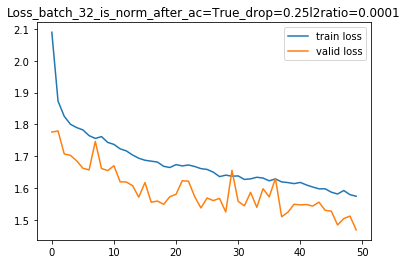

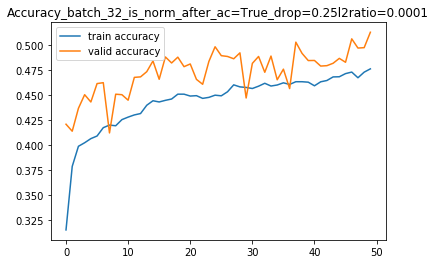

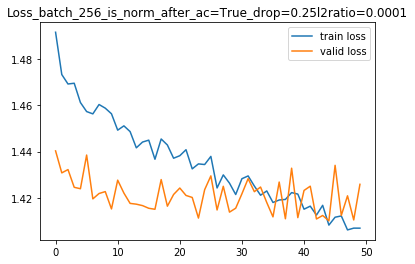

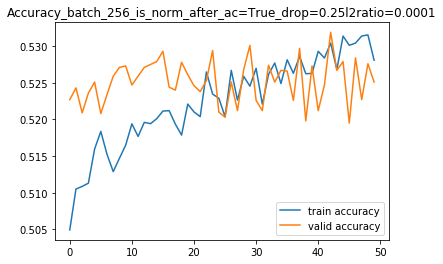

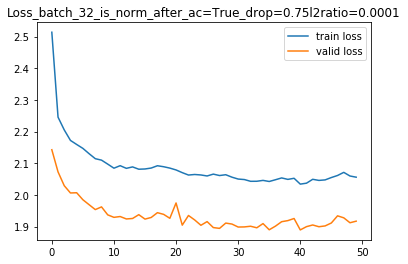

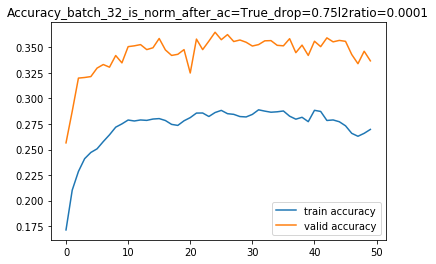

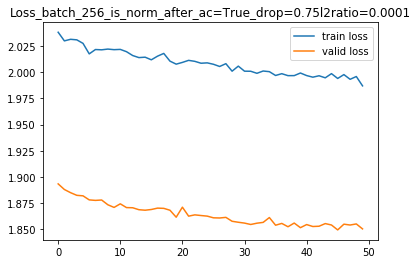

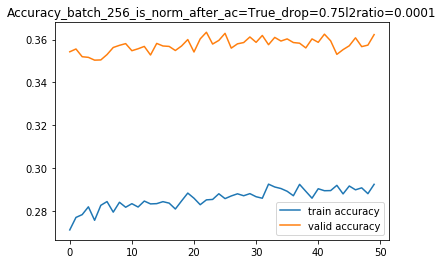

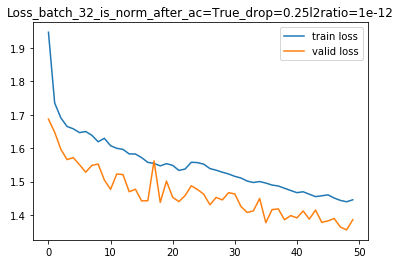

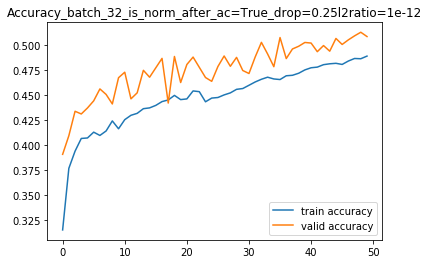

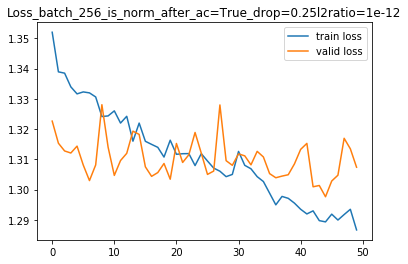

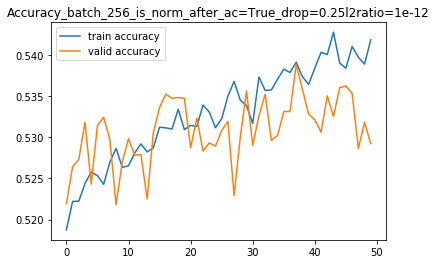

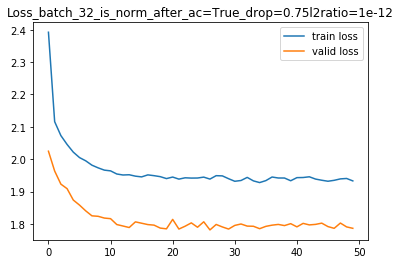

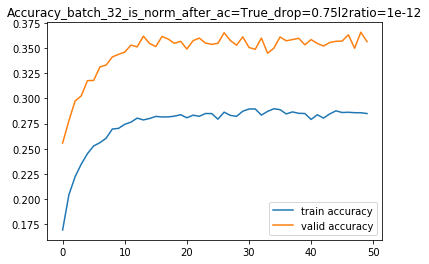

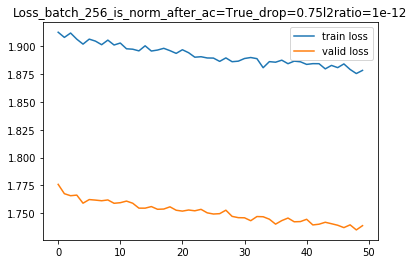

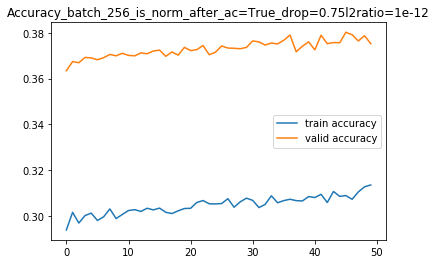

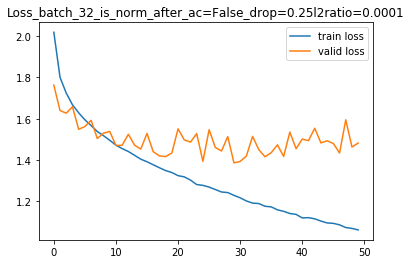

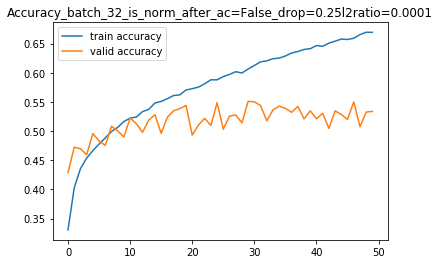

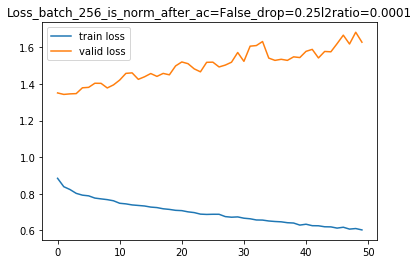

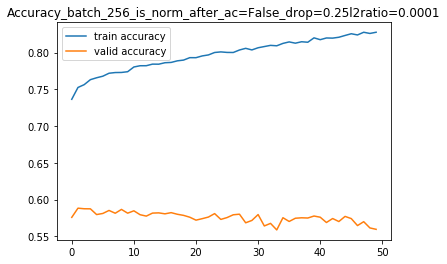

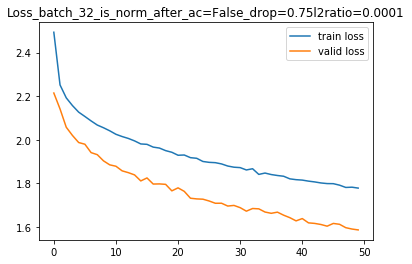

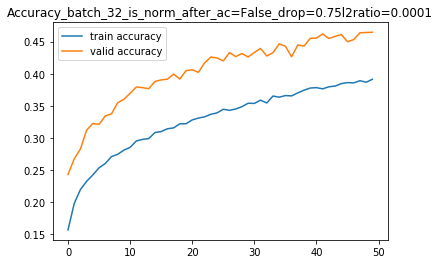

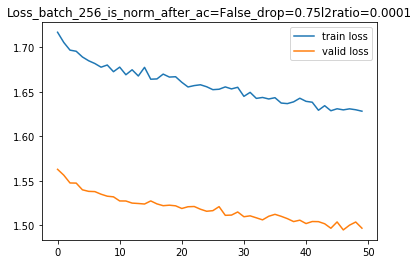

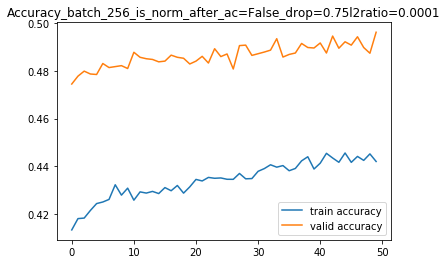

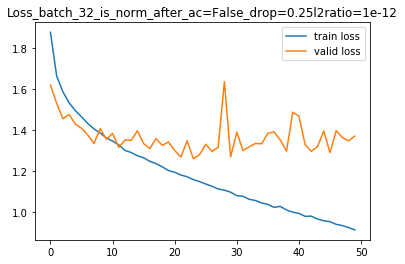

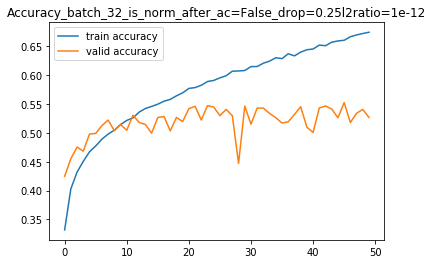

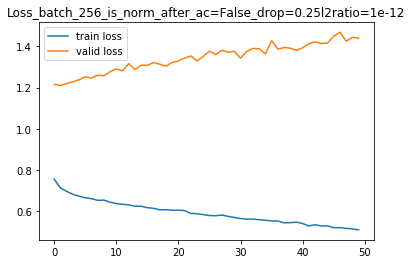

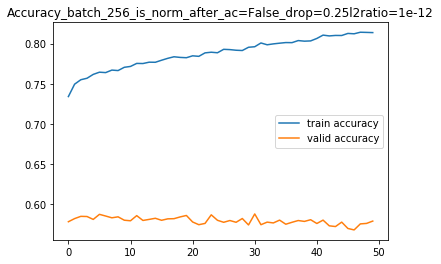

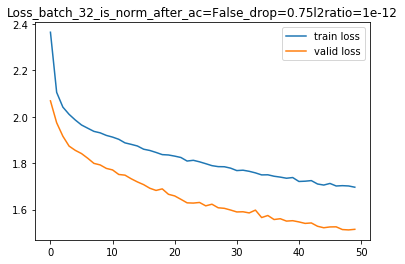

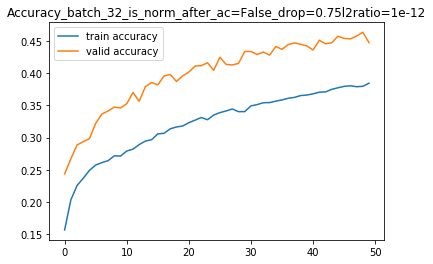

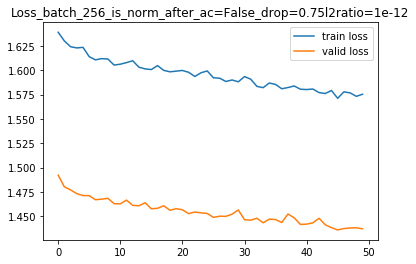

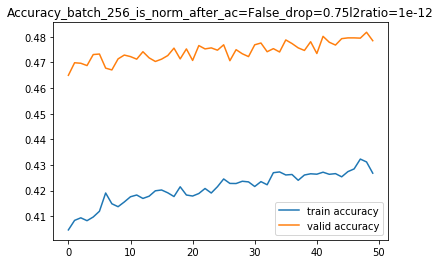

In [9]:
for is_norm_after_ac in IS_NORM_AFTER_AC:
    for l2ratio in L2_EXP:
        for drop in DROPOUT:
            for batch in BATCH_SIZE:
                key = 'batch_'+str(batch)+"_is_norm_after_ac="+str(is_norm_after_ac)+"_drop="+str(drop)+"l2ratio="+str(l2ratio)
                result = results[key]
                train_loss = result[0]
                valid_loss = result[1]
                train_acc = result[2]
                valid_acc = result[3]

                plt.plot(range(len(train_loss)), train_loss, label="train loss")
                plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
                plt.legend()
                plt.title("Loss_"+key)
                plt.show()

                plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
                plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
                plt.legend()
                plt.title("Accuracy_"+key)
                plt.show()